# DSCI 552 Homework 5

Name: Ziyue Chen

Github Username: zic115

USC ID: 8823457220

In [1]:
# Import packages
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import _tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

import statsmodels.api as sm

!pip install xgboost
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# 1. Decision Trees as Interpretable Models

## 1. (b) Build a decision tree on the whole data set and plot it

In [2]:
# Import diagnosis data
colnames = ['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain', 'Urine pushing', 'Micturition pains',
            'Burning of urethra, itch, swelling of urethra outlet', 'Inflammation of urinary bladder',
            'Nephritis of renal pelvis origin']
diagnosis = pd.read_csv('../data/diagnosis.data', encoding = 'utf-16', sep = '\t', names = colnames, header = None)
diagnosis

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing,Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Inflammation of urinary bladder,Nephritis of renal pelvis origin
0,"35,5",no,yes,no,no,no,no,no
1,"35,9",no,no,yes,yes,yes,yes,no
2,"35,9",no,yes,no,no,no,no,no
3,"36,0",no,no,yes,yes,yes,yes,no
4,"36,0",no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,"41,4",no,yes,yes,no,yes,no,yes
116,"41,5",no,no,no,no,no,no,no
117,"41,5",yes,yes,no,yes,no,no,yes
118,"41,5",no,yes,yes,no,yes,no,yes


In [3]:
# Preprocess the data
diagnosis['Temperature of patient'] = diagnosis['Temperature of patient'].str.replace(',', '.').astype(float)
diagnosis_dummies = pd.get_dummies(diagnosis[colnames], drop_first = True)
diagnosis_dummies

,Temperature of patient,Occurrence of nausea_yes,Lumbar pain_yes,Urine pushing_yes,Micturition pains_yes,"Burning of urethra, itch, swelling of urethra outlet_yes",Inflammation of urinary bladder_yes,Nephritis of renal pelvis origin_yes
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


In [4]:
# Build a decision tree
X = diagnosis_dummies.iloc[:, :-2]
y = diagnosis_dummies.iloc[:, -2:]

tree = DecisionTreeClassifier(random_state = 42)
tree = tree.fit(X, y)

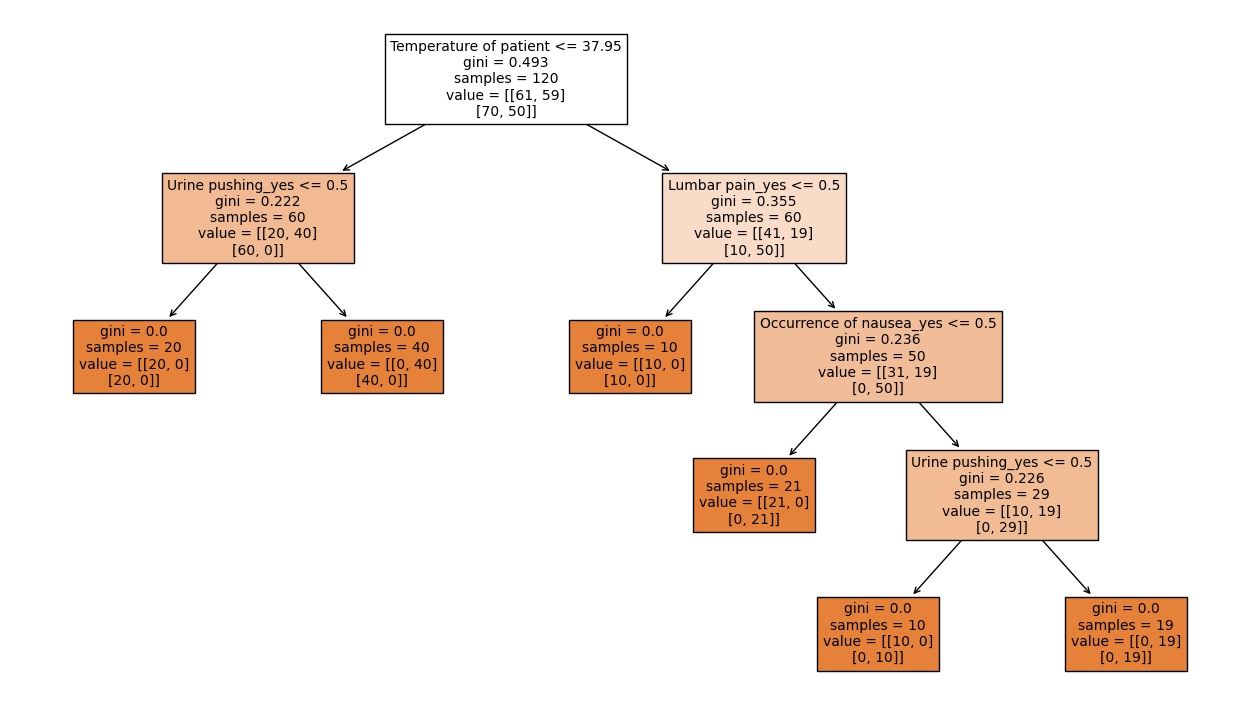

In [5]:
# Plot the decision tree
plt.rcParams['figure.figsize'] = [16, 9]
plot_tree(tree, feature_names = list(X.columns), filled = True)
plt.show()

## 1. (c) Convert the decision rules into a set of IF-THEN rules

In [6]:
# Defind a function for conversion
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else 'undefined!' for i in tree_.feature]
    print('def tree({}):'.format(', '.join(feature_names)))

    def recurse(node, depth):
        indent = '    ' * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print('{}if {} <= {}:'.format(indent, name, threshold))
            
            recurse(tree_.children_left[node], depth + 1)
            print('{}else:  # if {} > {}'.format(indent, name, threshold))
            
            recurse(tree_.children_right[node], depth + 1)
        else:
            print('{}return {}'.format(indent, tree_.value[node]))

    recurse(0, 1)

In [7]:
# Print the IF-THEN rules
tree_to_code(tree, list(X.columns))

def tree(Temperature of patient, Occurrence of nausea_yes, Lumbar pain_yes, Urine pushing_yes, Micturition pains_yes, Burning of urethra, itch, swelling of urethra outlet_yes):
    if Temperature of patient <= 37.95000076293945:
        if Urine pushing_yes <= 0.5:
            return [[20.  0.]
 [20.  0.]]
        else:  # if Urine pushing_yes > 0.5
            return [[ 0. 40.]
 [40.  0.]]
    else:  # if Temperature of patient > 37.95000076293945
        if Lumbar pain_yes <= 0.5:
            return [[10.  0.]
 [10.  0.]]
        else:  # if Lumbar pain_yes > 0.5
            if Occurrence of nausea_yes <= 0.5:
                return [[21.  0.]
 [ 0. 21.]]
            else:  # if Occurrence of nausea_yes > 0.5
                if Urine pushing_yes <= 0.5:
                    return [[10.  0.]
 [ 0. 10.]]
                else:  # if Urine pushing_yes > 0.5
                    return [[ 0. 19.]
 [ 0. 19.]]


## 1. (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability

In [8]:
# Cross validate for best alpha
path = tree.cost_complexity_pruning_path(X, y)
alphas = path.ccp_alphas
param = {'ccp_alpha': alphas}

clf = GridSearchCV(tree, param, cv = 5)
clf = clf.fit(X, y)
cv_results = clf.cv_results_
cv_results

{'mean_fit_time': array([0.00179777, 0.00161724, 0.00150137, 0.00149627, 0.00144458]),
 'std_fit_time': array([3.59395636e-04, 2.08698415e-04, 1.12127464e-04, 5.70810925e-05,
        2.66879755e-05]),
 'mean_score_time': array([0.00154519, 0.00097342, 0.00094376, 0.00094347, 0.00090961]),
 'std_score_time': array([1.02293393e-03, 4.65866243e-05, 3.08586227e-05, 2.54482769e-05,
        3.43322754e-06]),
 'param_ccp_alpha': masked_array(data=[0.0, 0.04908333333333333, 0.07947222222222226,
                    0.1111111111111111, 0.204236111111111],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ccp_alpha': 0.0},
  {'ccp_alpha': 0.04908333333333333},
  {'ccp_alpha': 0.07947222222222226},
  {'ccp_alpha': 0.1111111111111111},
  {'ccp_alpha': 0.204236111111111}],
 'split0_test_score': array([1.        , 1.        , 1.        , 0.54166667, 0.54166667]),
 'split1_test_score': array([1.  , 1.  , 1.  , 0.75, 0.  ]),
 'spli

In [9]:
# Choose the best alpha > 0
scores = cv_results['mean_test_score']
for i in range(1, len(scores)):
    if scores[i] == max(scores[1:]):
        best_alpha = alphas[i]

print('alpha (> 0) chosen by cross-validation:', best_alpha)

alpha (> 0) chosen by cross-validation: 0.04908333333333333


In [10]:
# Use the best alpha to build the minimal decision tree
min_tree = DecisionTreeClassifier(ccp_alpha = best_alpha, random_state = 42)
min_tree = min_tree.fit(X, y)

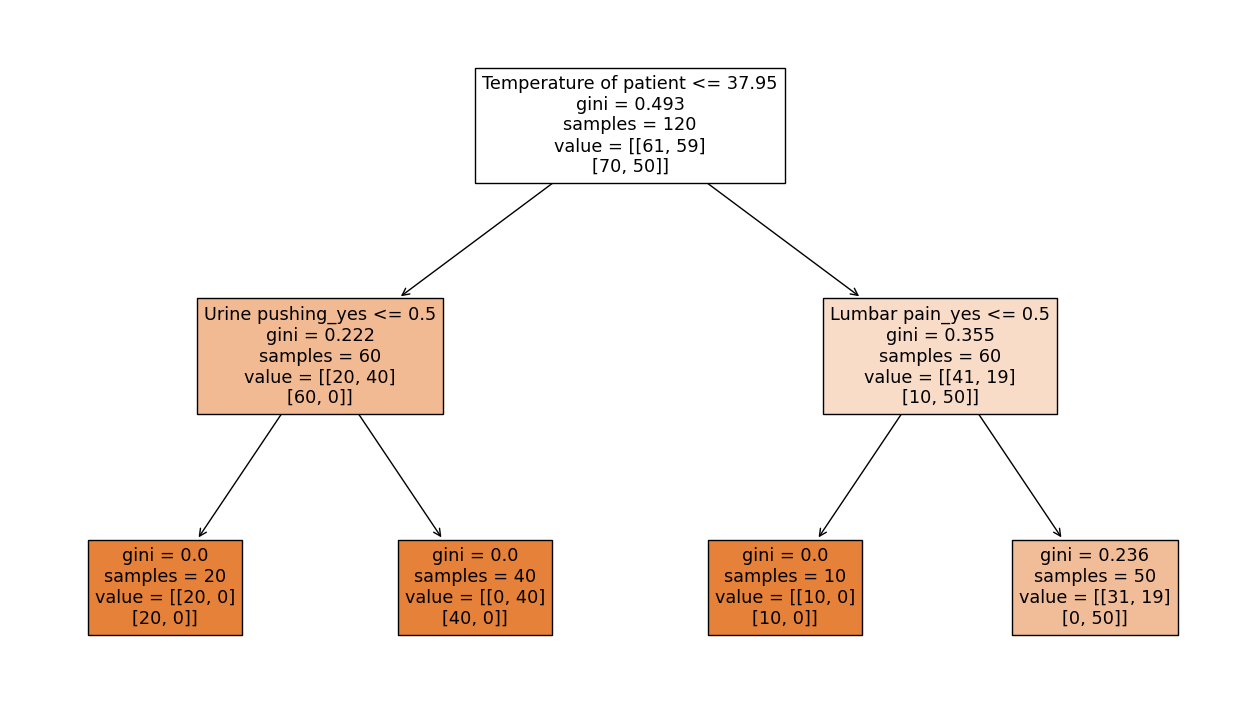

In [11]:
# Plot the minimal decision tree
plt.rcParams['figure.figsize'] = [16, 9]
plot_tree(min_tree, feature_names = list(X.columns), filled = True)
plt.show()

In [12]:
# Print the IF-THEN rules
tree_to_code(min_tree, list(X.columns))

def tree(Temperature of patient, Occurrence of nausea_yes, Lumbar pain_yes, Urine pushing_yes, Micturition pains_yes, Burning of urethra, itch, swelling of urethra outlet_yes):
    if Temperature of patient <= 37.95000076293945:
        if Urine pushing_yes <= 0.5:
            return [[20.  0.]
 [20.  0.]]
        else:  # if Urine pushing_yes > 0.5
            return [[ 0. 40.]
 [40.  0.]]
    else:  # if Temperature of patient > 37.95000076293945
        if Lumbar pain_yes <= 0.5:
            return [[10.  0.]
 [10.  0.]]
        else:  # if Lumbar pain_yes > 0.5
            return [[31. 19.]
 [ 0. 50.]]


# 2. The LASSO and Boosting for Regression

## 2. (a) Download the Communities and Crime data and use the first 1495 rows as the training set and the rest as the test set

In [13]:
# Import communities data
with open('../data/communities.names') as f:
    lines = f.readlines()

header = []
for line in lines[75: 203]:
    if line.startswith('@attribute'):
        line = line.replace('@attribute ', '').replace(' numeric\n', '').replace(' string\n', '')
        header.append(line)

communities = pd.read_csv('../data/communities.csv', names = header, header = None)
communities

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [14]:
# Preprocess the data
communities = communities.replace('?', np.nan)
communities.iloc[:, 5:] = communities.iloc[:, 5:].astype(float)
communities

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [15]:
# Split training and test data
train = communities.iloc[:1495, :]
test = communities.iloc[1495:, :]

## 2. (b) Use a data imputation technique to deal with the missing values

In [16]:
# Use the mean of a feature to replace its missing values (ignore nonpredictive features)
non_predictive = ['state', 'county', 'community', 'communityname', 'fold']
goal = 'ViolentCrimesPerPop'
predictive = []
for feature in list(communities.columns):
    if feature not in non_predictive and feature != goal:
        predictive.append(feature)

for feature in predictive:
    mean = communities[feature].mean()
    communities[feature] = communities[feature].replace(np.nan, mean)

communities

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


In [17]:
# Re-split training and test data
train = communities.iloc[:1495, 5:]
test = communities.iloc[1495:, 5:]

## 2. (c) Plot a correlation matrix for the features

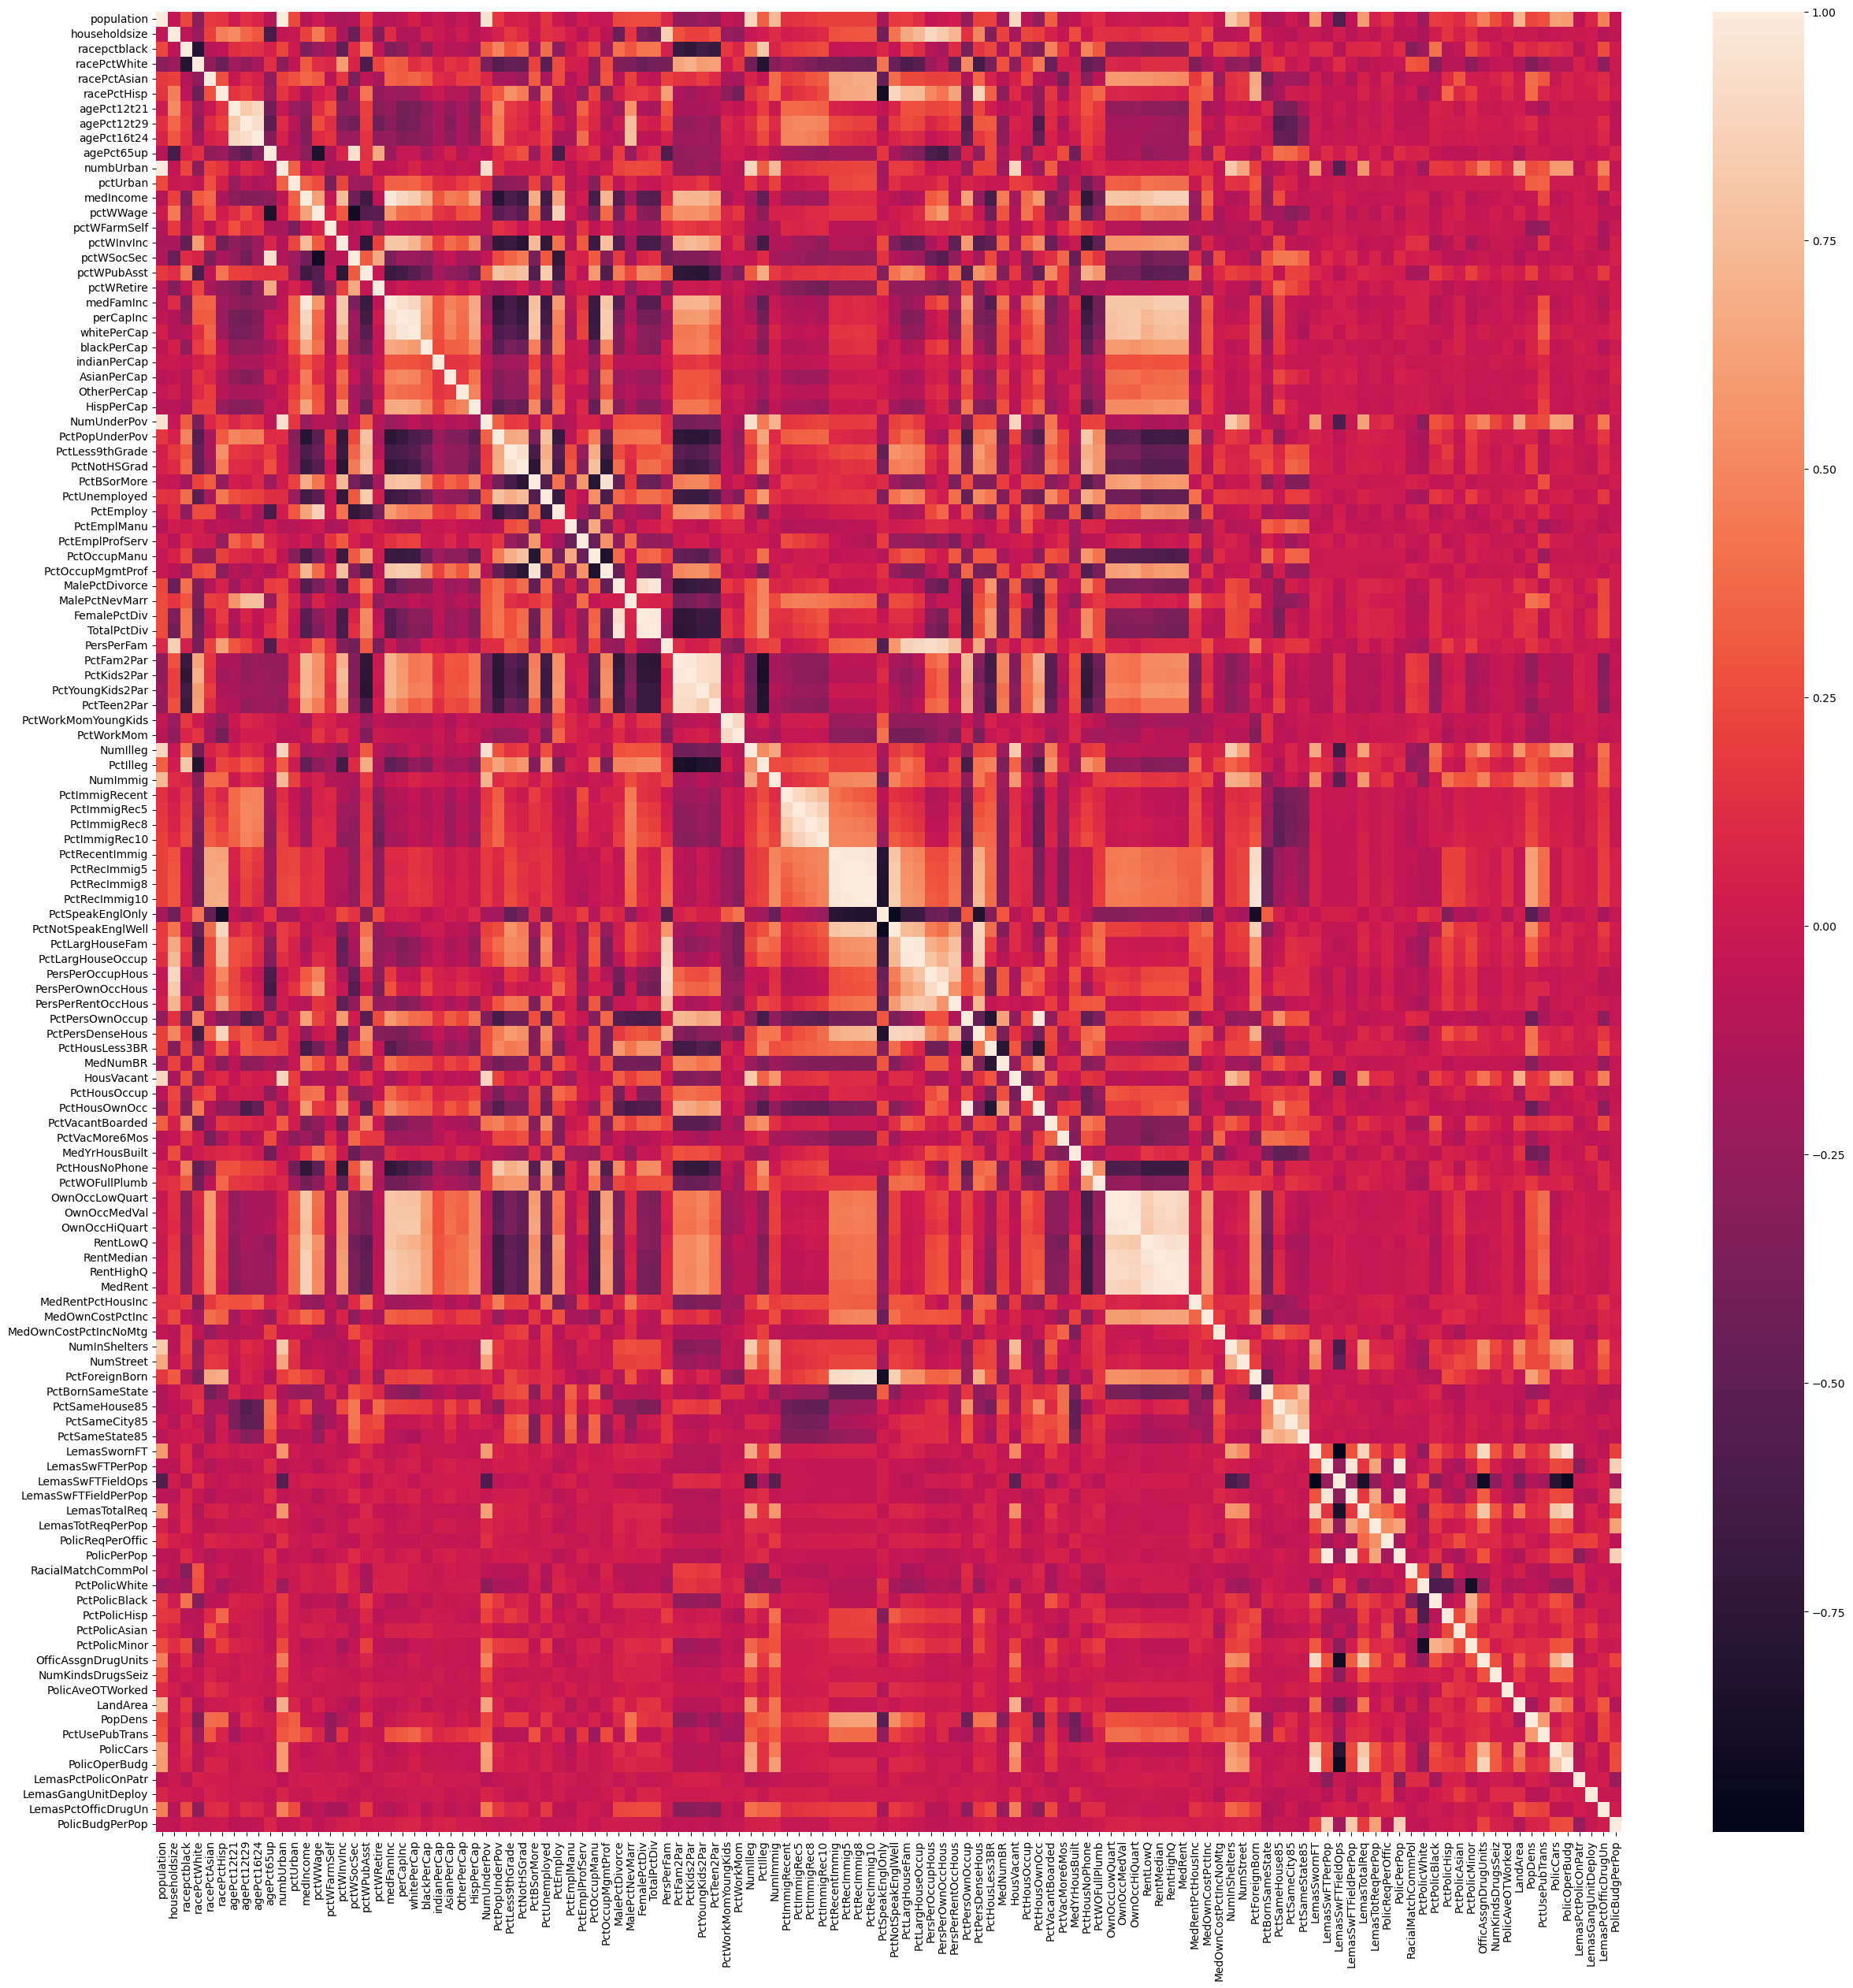

In [18]:
# Correlation matrix
corr = communities[predictive].corr()
plt.rcParams['figure.figsize'] = [30, 30]
sns.heatmap(corr)
plt.show()

## 2. (d) Calculate the Coefficient of Variation CV for each feature

In [19]:
# Define a function to calculate CV
def calculateCV(column):
    std = column.std()
    mean = column.mean()
    CV = std / mean
    return CV

In [20]:
# Calculate CV for each feature
CV_values = {}
for feature in predictive:
    CV = calculateCV(communities[feature])
    CV_values[feature] = CV

CV_values

{'population': 2.203502536390972,
 'householdsize': 0.3532983018683109,
 'racepctblack': 1.4109203963756864,
 'racePctWhite': 0.3237815624993411,
 'racePctAsian': 1.3591621938222074,
 'racePctHisp': 1.614277791710685,
 'agePct12t21': 0.36583986883972397,
 'agePct12t29': 0.29069288841904145,
 'agePct16t24': 0.4951605143654288,
 'agePct65up': 0.42344170889026195,
 'numbUrban': 2.0017436381957676,
 'pctUrban': 0.6388488712113656,
 'medIncome': 0.5797533935755996,
 'pctWWage': 0.3277100586060616,
 'pctWFarmSelf': 0.7000301156104908,
 'pctWInvInc': 0.35923994722340613,
 'pctWSocSec': 0.36851263032540155,
 'pctWPubAsst': 0.699030504203365,
 'pctWRetire': 0.3496390828575848,
 'medFamInc': 0.527731885342079,
 'perCapInc': 0.545633428419145,
 'whitePerCap': 0.5075521907214038,
 'blackPerCap': 0.5894690036844645,
 'indianPerCap': 0.8096850868666168,
 'AsianPerCap': 0.6061938508790911,
 'OtherPerCap': 0.6706445725467309,
 'HispPerCap': 0.4739597186074789,
 'NumUnderPov': 2.304969714852185,
 'PctP

## 2. (e) Pick ⌊√128⌋ features with highest CV and make scatter plots and box plots for them

In [21]:
# Pick features
sorted_CV_values = sorted(CV_values.items(), key = lambda x: x[1], reverse = True)
n = math.floor(math.sqrt(128))
selected = sorted_CV_values[:n]
selected

[('NumStreet', 4.407702440863974),
 ('NumInShelters', 3.4854812687233436),
 ('NumIlleg', 2.9941964494842983),
 ('NumImmig', 2.9004971638852743),
 ('LemasPctOfficDrugUn', 2.555266002927139),
 ('NumUnderPov', 2.304969714852185),
 ('population', 2.203502536390972),
 ('numbUrban', 2.0017436381957676),
 ('HousVacant', 1.9587797297820901),
 ('LandArea', 1.6780314766044726),
 ('racePctHisp', 1.614277791710685)]

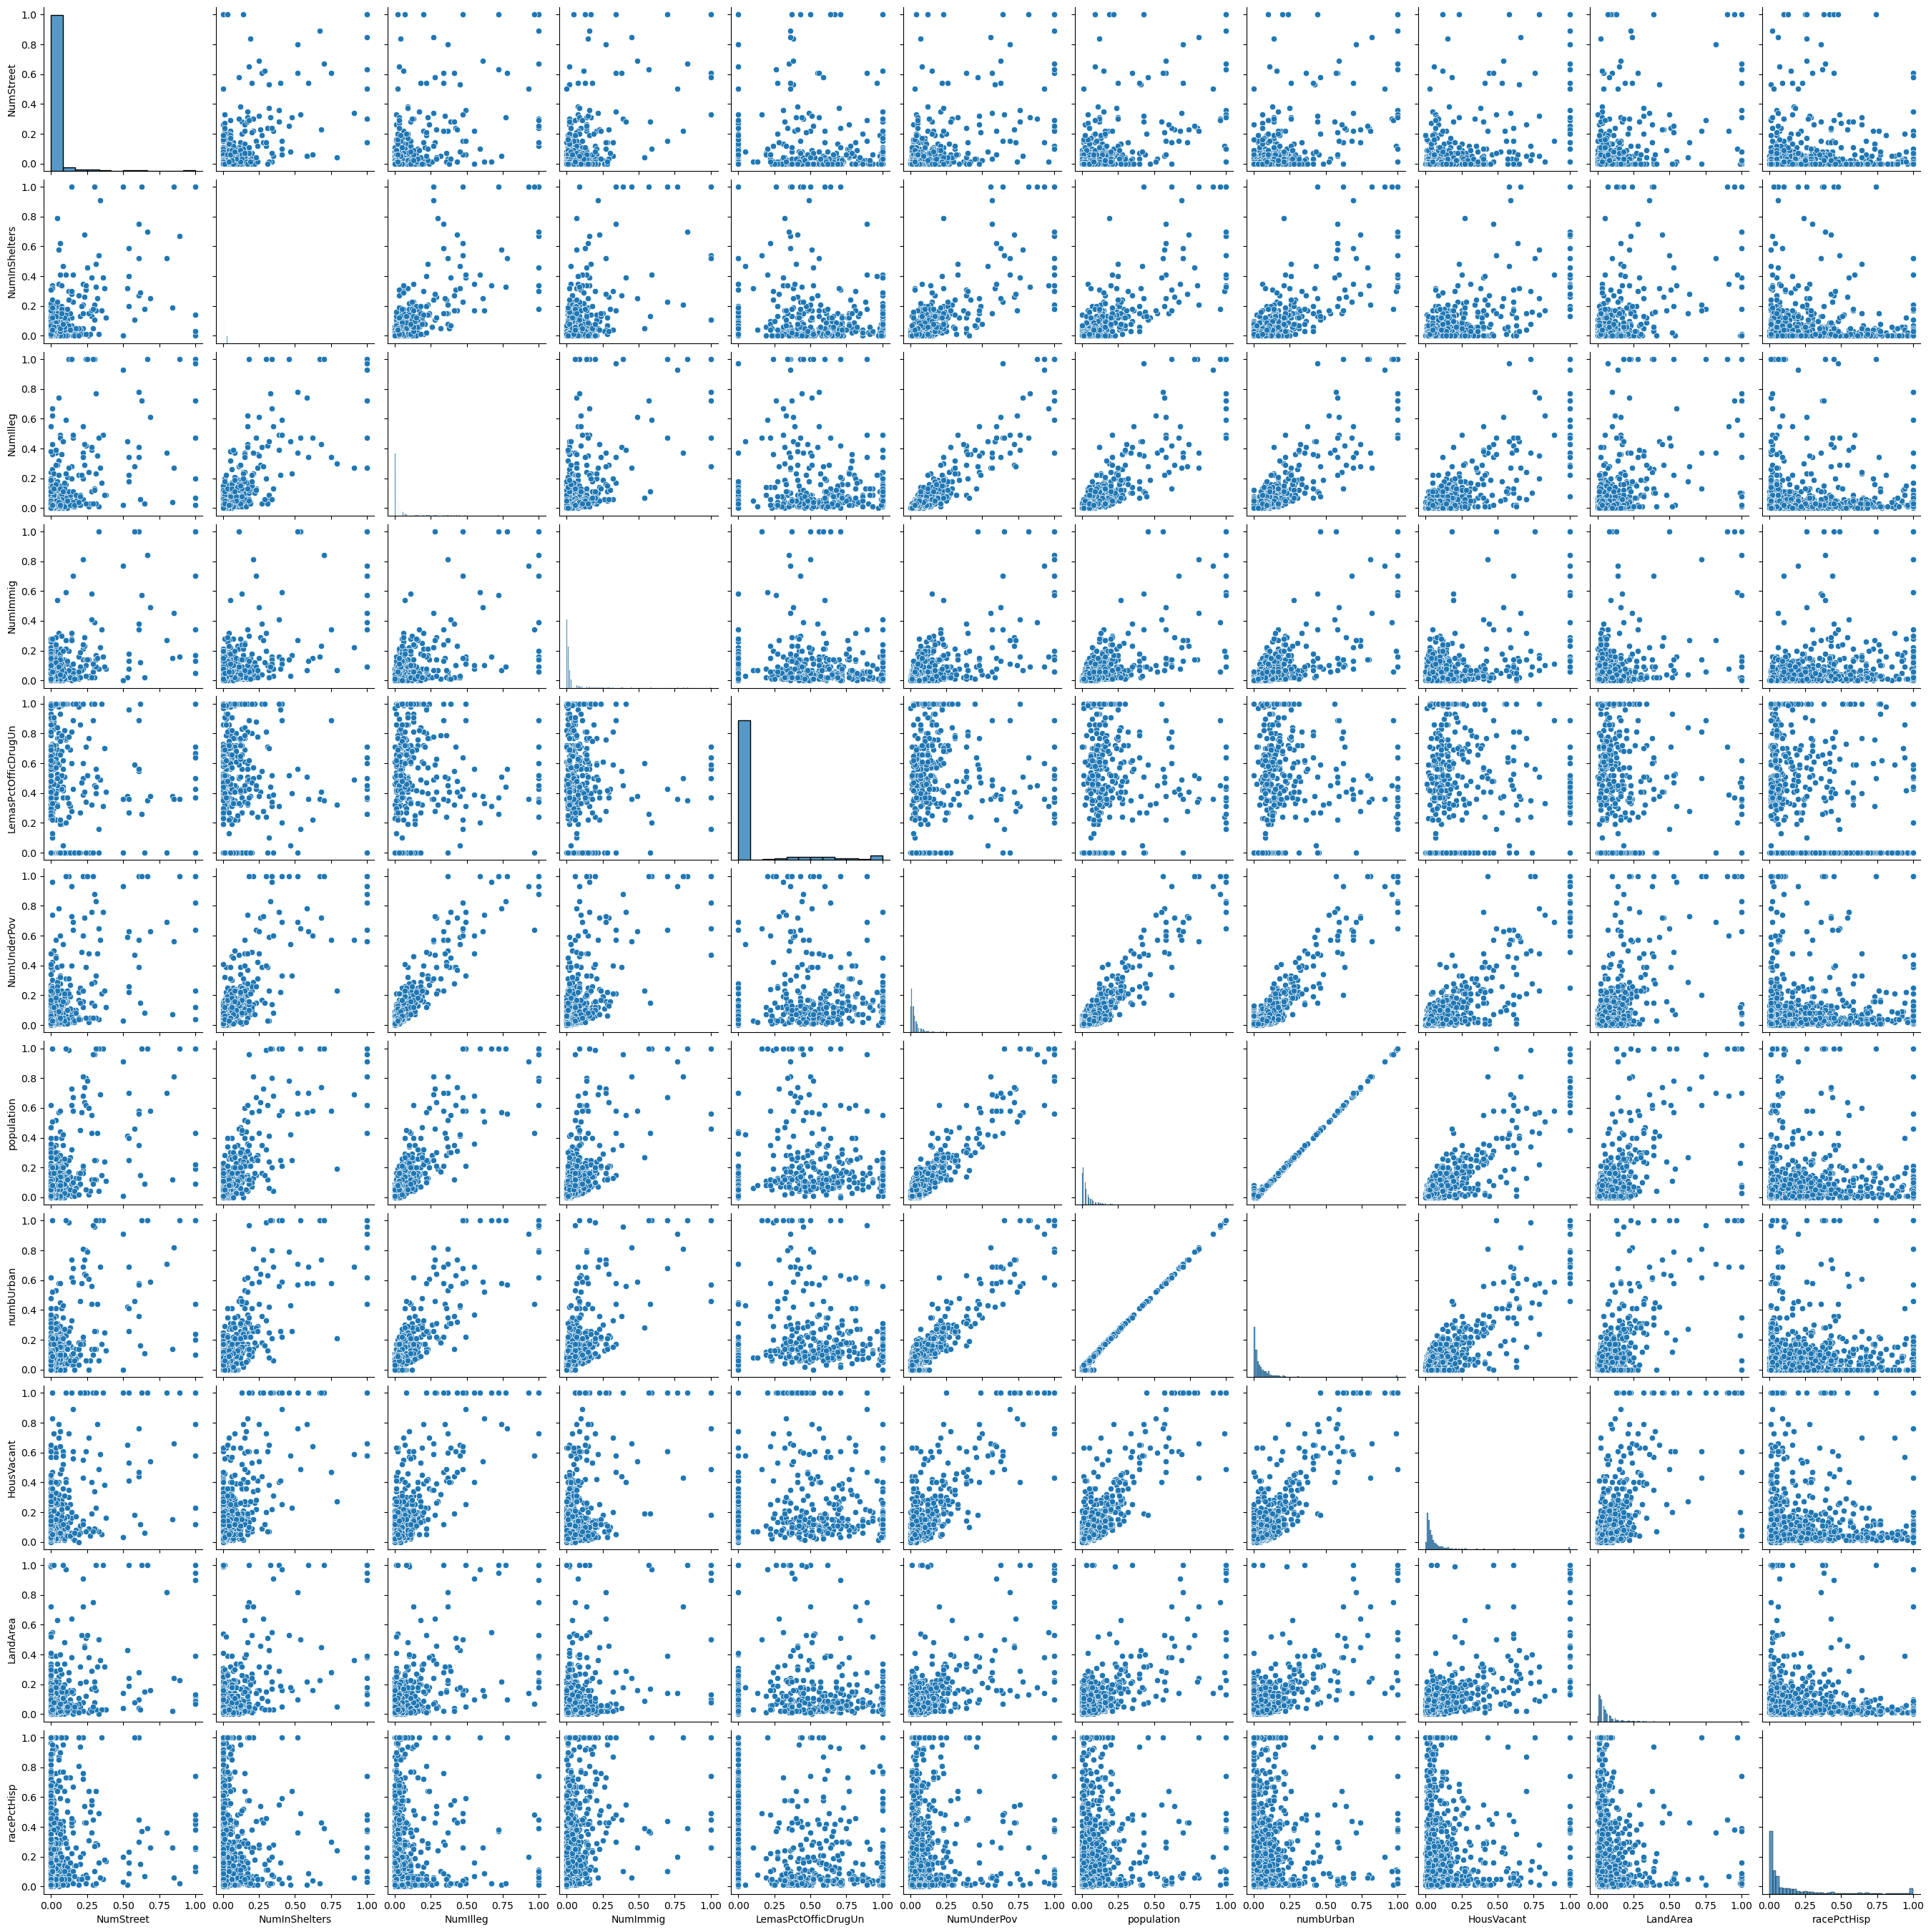

In [22]:
# Pairplot
selected_features = [selected[i][0] for i in range(len(selected))]
sns.pairplot(communities[selected_features])
plt.show()

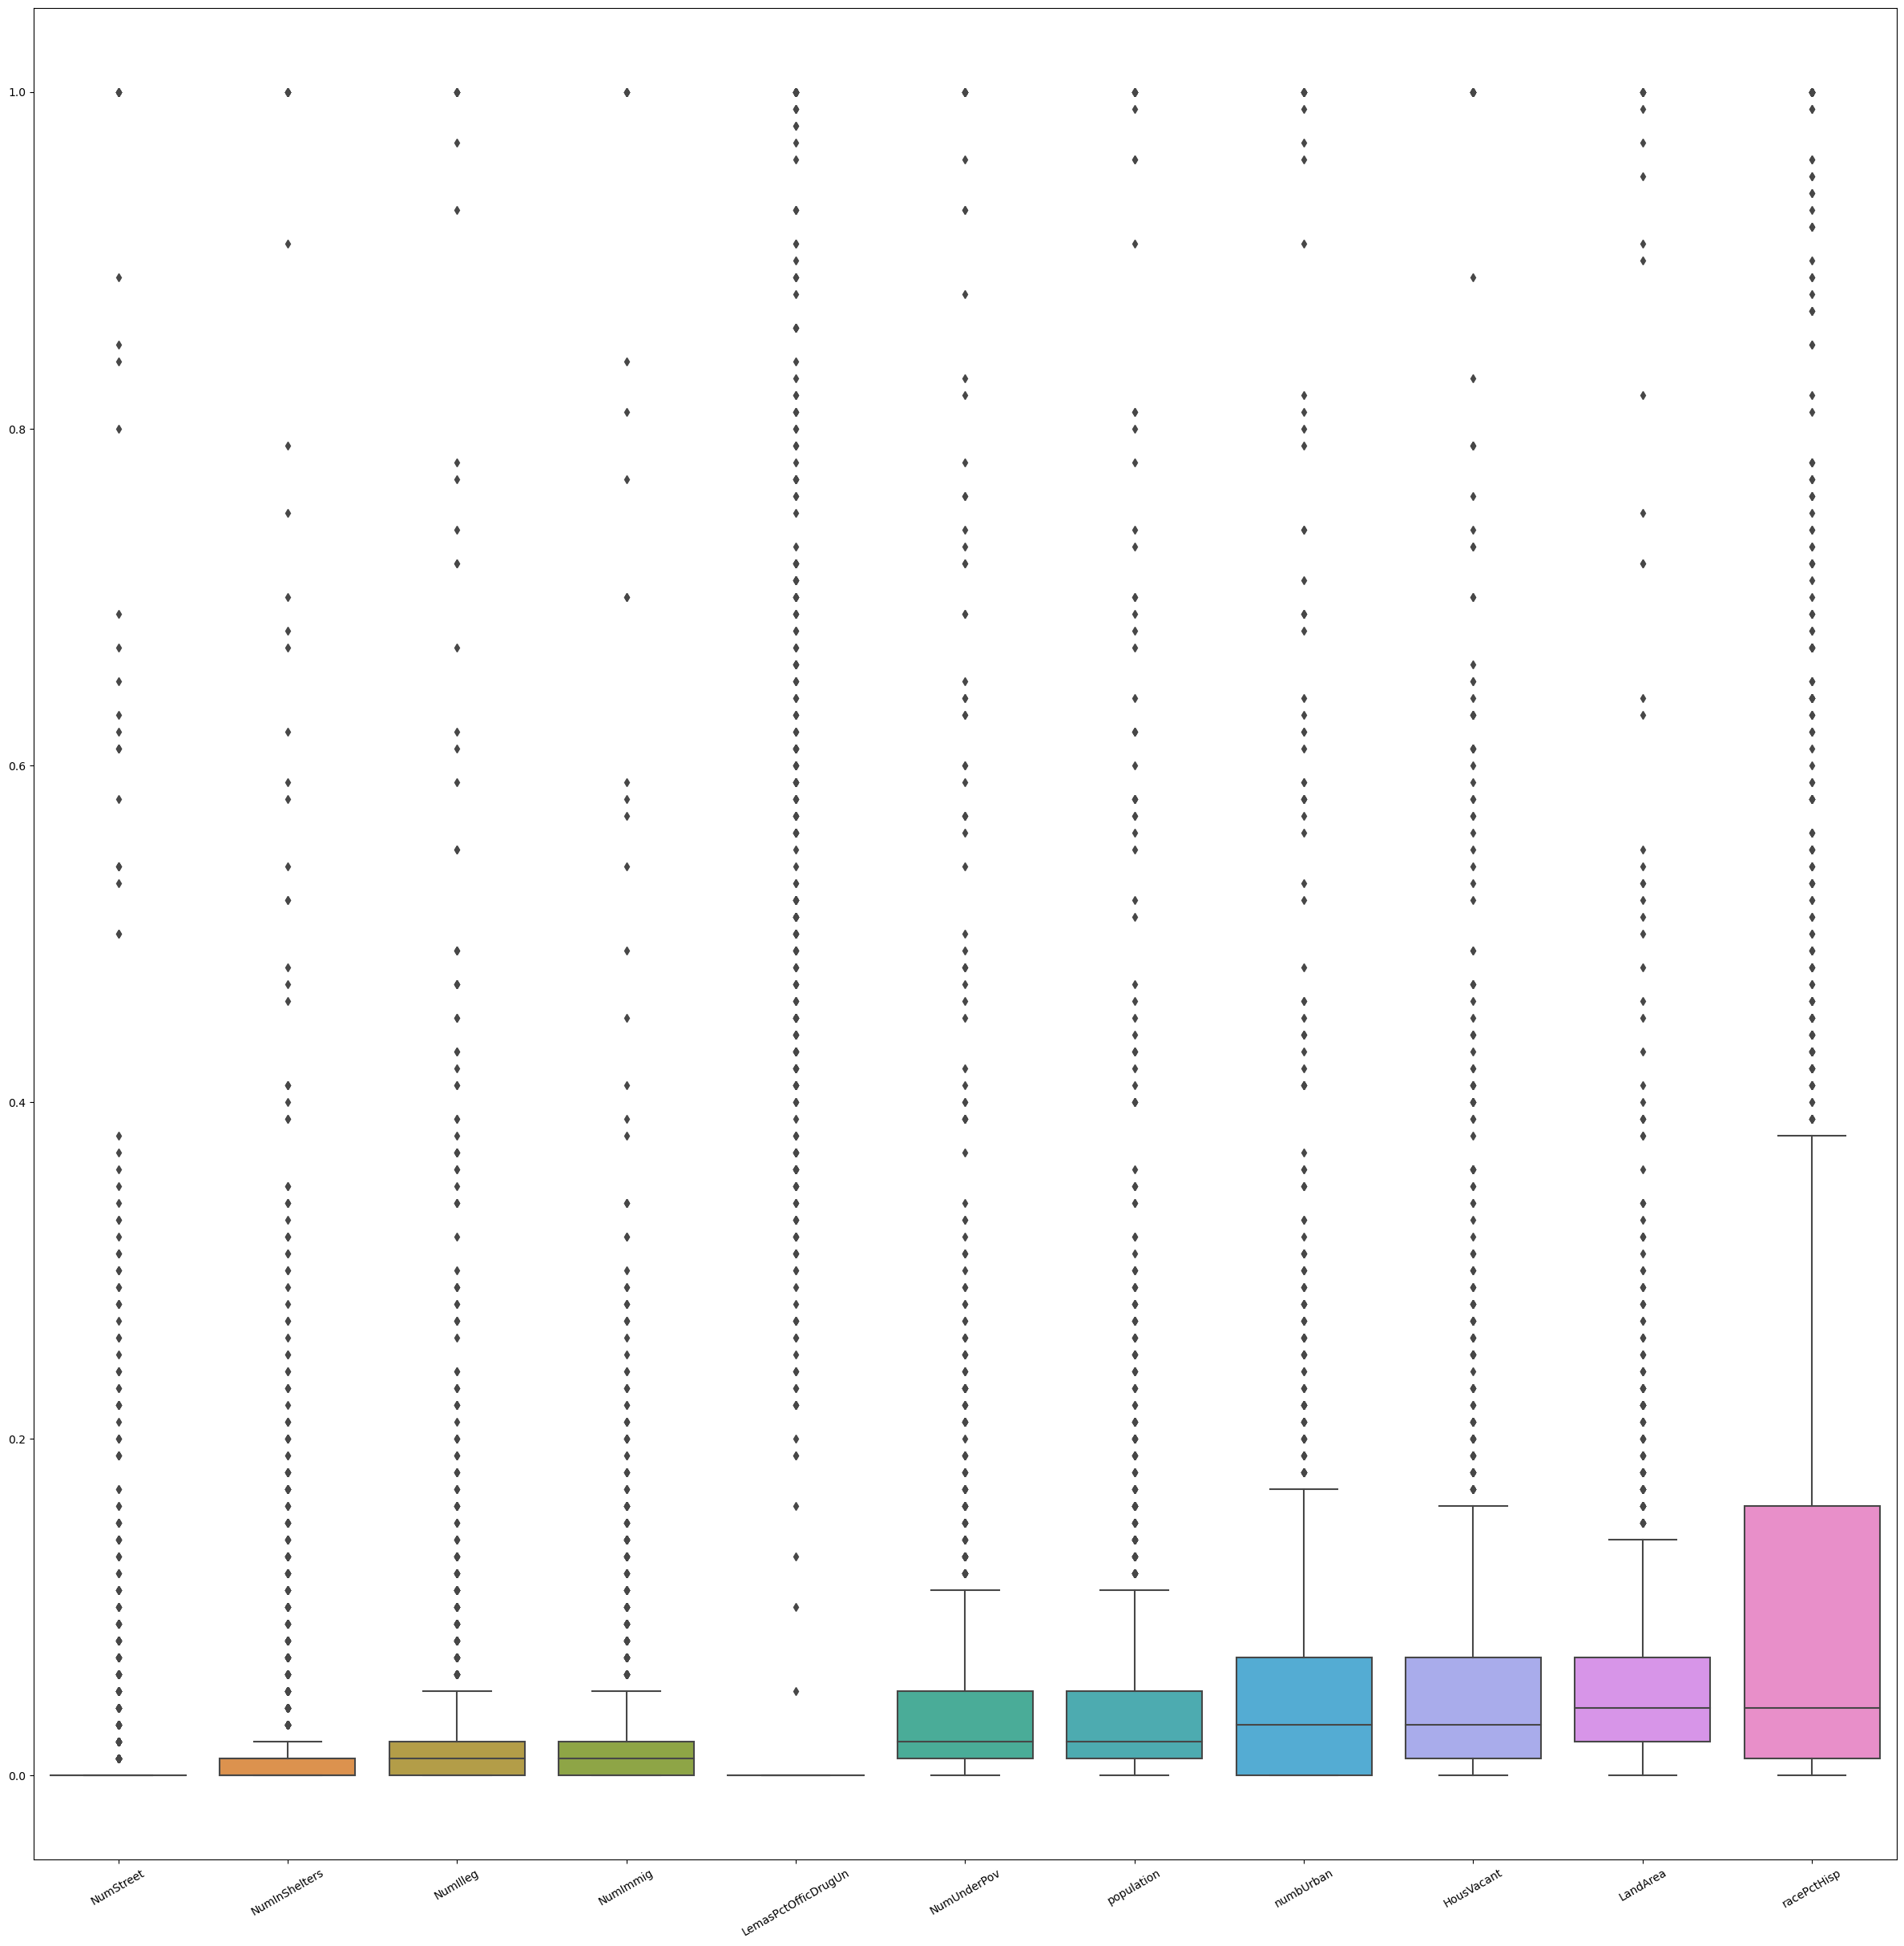

In [23]:
# Boxplot
sns.boxplot(data = communities[selected_features])
plt.xticks(rotation = 30)
plt.show()

Just by the pairplot, the significance of the selected features cannot be concluded, but we can observe correlation between some selected features such as population and numbUrban that have a strong linear relationship.

## 2. (f) Fit a linear model using least squares

In [24]:
# Generate X_train, y_train, X_test, y_test
X_train = train.iloc[:, :-1]
X_train = sm.add_constant(X_train)
y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
X_test = sm.add_constant(X_test)
y_test = test.iloc[:, -1]

In [25]:
# Fit a linear model
linear = sm.OLS(y_train, X_train)
linear = linear.fit()

In [26]:
# Test error
y_pred = linear.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print('linear model test error:', test_error)

linear model test error: 0.7897255274659005


## 2. (g) Fit a ridge regression model, with λ chosen by cross-validation

In [27]:
# Fit a Ridge regression model with cross validation
alphas = np.linspace(1e-4, 1e4, 1000)
ridge = RidgeCV(alphas = alphas)
ridge = ridge.fit(X_train, y_train)

In [28]:
# Choose the best alpha and lambda
alpha_ = ridge.alpha_
lambda_ = alpha_
print('alpha chosen by cross-validation:', alpha_)
print('lambda chosen by cross-validation:', lambda_)

alpha chosen by cross-validation: 10.010109909909911
lambda chosen by cross-validation: 10.010109909909911


In [29]:
# Test error
y_pred = ridge.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print('Ridge regression model test error:', test_error)

Ridge regression model test error: 0.017440181980626596


## 2. (h) Fit a LASSO model, with λ chosen by cross-validation, and repeat with standardized features

In [30]:
# Fit a Lasso regression model with cross validation
lasso = LassoCV(alphas = alphas, random_state = 42)
lasso = lasso.fit(X_train, y_train)

In [31]:
# Choose the best alpha and lambda
alpha_ = lasso.alpha_
lambda_ = alpha_
print('alpha chosen by cross-validation:', alpha_)
print('lambda chosen by cross-validation:', lambda_)

alpha chosen by cross-validation: 0.0001
lambda chosen by cross-validation: 0.0001


In [32]:
# Test error
y_pred = lasso.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print('Lasso regression model test error:', test_error)

Lasso regression model test error: 0.017790185551932517


In [33]:
# Variables selected by the model
lasso = Lasso(alpha = alpha_)
lasso = lasso.fit(X_train, y_train)

lasso_selected = []
for i in range(len(lasso.coef_)):
    if abs(lasso.coef_[i]) != 0:
        lasso_selected.append(lasso.feature_names_in_[i])

print('selected features:', lasso_selected)

selected features: ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctSameCity85', 'LemasSw

In [34]:
# Standardize features and repeat
X_train_s = train.iloc[:, :-1]
X_test_s = test.iloc[:, :-1]

scaler = StandardScaler()
X_train_s[:] = scaler.fit_transform(X_train_s[:])
X_train_s = sm.add_constant(X_train_s)

X_test_s[:] = scaler.transform(X_test_s[:])
X_test_s = sm.add_constant(X_test_s)

In [35]:
# Fit a Lasso regression model with cross validation
lasso_s = LassoCV(alphas = alphas, random_state = 42)
lasso_s = lasso_s.fit(X_train_s, y_train)

In [36]:
# Choose the best alpha and lambda
alpha_s = lasso_s.alpha_
lambda_s = alpha_s
print('alpha chosen by cross-validation:', alpha_s)
print('lambda chosen by cross-validation:', lambda_s)

alpha chosen by cross-validation: 0.0001
lambda chosen by cross-validation: 0.0001


In [37]:
# Test error
y_pred = lasso_s.predict(X_test_s)
test_error_s = mean_squared_error(y_test, y_pred)
print('Lasso regression model test error:', test_error_s)

Lasso regression model test error: 0.01792467211163164


In [38]:
# Variables selected by the model
lasso_s = Lasso(alpha = alpha_s)
lasso_s = lasso_s.fit(X_train_s, y_train)

lasso_s_selected = []
for i in range(len(lasso_s.coef_)):
    if abs(lasso_s.coef_[i]) != 0:
        lasso_s_selected.append(lasso_s.feature_names_in_[i])

print('selected features:', lasso_s_selected)

selected features: ['population', 'householdsize', 'racepctblack', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseH

The test error for unstandardized features is 0.017790185551932517, and the test error for standardized features is 0.01792467211163164. The two values are similar. However, there is a difference in selected features between the two models.

## 2. (i) Fit a PCR model, with M (the number of principal components) chosen by cross-validation

In [39]:
# Apply PCA to features
X_train = train.iloc[:, :-1]
X_test = test.iloc[:, :-1]

pca = PCA()
X_train_reduced = pca.fit_transform(scale(X_train))

In [40]:
# Cross validate for best M
M = []
cv_scores = []
for i in range(1, 122):
    M.append(i)
    cv_score = cross_val_score(estimator = LinearRegression(), X = X_train_reduced[:, :i], y = y_train, cv = 10).mean()
    cv_scores.append(cv_score)

In [41]:
# Choose the best M
for i in range(len(cv_scores)):
    if cv_scores[i] == max(cv_scores):
        best_M = M[i]
print('M chosen by cross-validation:', best_M)

M chosen by cross-validation: 95


In [42]:
# Use the best M to build the PCR model
X_train_reduced = X_train_reduced[:, :95]
X_test_reduced = pca.transform(scale(X_test))[:, :95]

lr = LinearRegression()
lr = lr.fit(X_train_reduced, y_train)

In [43]:
# Test error
y_pred = lr.predict(X_test_reduced)
test_error = mean_squared_error(y_test, y_pred)
print('PCR model test error:', test_error)

PCR model test error: 0.018735172990159737


## 2. (j) Fit a boosting tree, with α (the number of principal components) chosen by cross-validation

In [44]:
# Cross validate for best alpha
alphas = np.linspace(1e-4, 1e4, 100)
param = {'reg_alpha': alphas}
xgb = XGBRegressor(objective = 'reg:squarederror', random_state = 42)

clf = GridSearchCV(xgb, param, cv = 5)
clf = clf.fit(X_train, y_train)

In [45]:
# Choose the best alpha
best_alpha = clf.best_params_['reg_alpha']
print('alpha chosen by cross-validation:', best_alpha)

alpha chosen by cross-validation: 0.0001


In [46]:
# Use the best alpha to build the boosting tree
xgb = XGBRegressor(objective = 'reg:squarederror', reg_alpha = best_alpha, random_state = 42)
xgb = xgb.fit(X_train, y_train)

In [47]:
# Test error
y_pred = xgb.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print('boosting tree model test error:', test_error)

boosting tree model test error: 0.018487463405660143
